In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import csv

In [2]:
def make_sentences(tokens,tags):
    """
    Function converts list of words into sentences with sentences of corresponding tags

    INPUT : Dataframe of tokens, Dataframe of tags

    OUTPUT : Zip of list of sentences, list of tags sentences
    """
    data = tokens.join(tags, on="id", how = "inner", rsuffix = "_tag").drop("id_tag",axis=1)
    sentences = []
    tags_list = []
    temp_tokens = []
    temp_tags = []
    for row in data.itertuples():
        word = row[2]
        tag = row[3]
        if word!='-DOCSTART-' and word!='.':
            temp_tokens.append(word)
            temp_tags.append(tag)
        if word=='.':
            sentences.append(' '.join(temp_tokens) + ' .')
            tags_list.append(' '.join(temp_tags) + ' .')
            temp_tokens = []
            temp_tags = []
    
    return zip(sentences,tags_list)

def load_data(sentence_file, tag_file=None):
    """Loads data from two files: one containing sentences and one containing tags.

    tag_file is optional, so this function can be used to load the test data.

    Suggested to split the data by the document-start symbol.

    """
    tokens = pd.read_csv(sentence_file)
    if tag_file:
        tags = pd.read_csv(tag_file)
    else:
        #dummy tags for test file
        tags = pd.DataFrame()
        tags['id'] = range(len(tokens))
        tags['tag'] = ['NNP']*len(tokens)

    return make_sentences(tokens,tags)

In [3]:
train_data = load_data("../data/train_x.csv", "../data/train_y.csv")

In [4]:
def nGramTagger(n):
    dic = {}
    tags = zip(*train_data)[1]
    for line in tags:
        line = line.split(' ')
        line = ['*']*n + line
        for i in range(n,len(line)):
            if n==1:
                item = line[i]
            else:
                item = tuple(line[i-n:i])
            if item in dic:
                dic[item]+=1
            else:
                dic[item]=1
    return dic

def wordTagger():
    dic = defaultdict(int) 
    for line1,line2 in train_data:
        for word,tag in zip(line1.split(' '),line2.split(' ')):
            dic[(word,tag)]+=1
    return dic

unigram = nGramTagger(1)
bigram = nGramTagger(2)
trigram = nGramTagger(3)

wordtag = wordTagger()

In [5]:
tag_set = unigram.keys()

In [6]:
def get_q(tag_penult,tag_last,tag_current):
    k=1
    if (tag_penult, tag_last) not in bigram:
        return 0.0
    return float(trigram.get((tag_penult, tag_last, tag_current),0.0) + k)/(bigram[(tag_penult, tag_last)] + k*len(bigram))

def get_e(word,tag):
    return float(wordtag.get((word,tag),0.0))/unigram[tag]

In [7]:
def prob_distibution(k):
    prob = []
    tag_list = zip(*unigram.keys())[0]
    for key1 in tag_list :
        for key2 in tag_list:
            if (key1,key2) in bigram:
                num = bigram.get((key1,key2),0.0) + k
            else:
                num=k
            den = unigram.get(key1,0.0) + (k*len(tag_list))
            prob.append(float(num)/den if den!=0 else 0.0)
    print prob.count(0.0)
    plt.plot(sorted(prob,reverse=True))
    plt.show()

2007


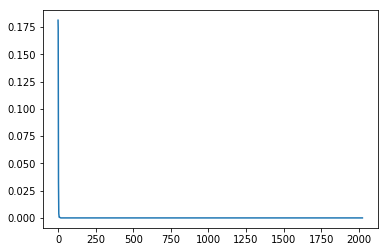

In [8]:
prob_distibution(0)

In [9]:
def sequence_probability(self, sequence, tags):
        """Computes the probability of a tagged sequence given the emission/transition
        probabilities.
        """
        tag_penult = '*'
        tag_prev = '*'
        prod = 1
        for word, tag in zip(sequence,tags):
            q = self.get_q(tag,tag_prev,tag_penult)
            e = self.get_e(word,tag)
            tag_penult = tag_prev
            tag_prev = tagger
            prod *= q*e

        return prod


In [10]:
def inference(sequence,mode):
        """Tags a sequence with part of speech tags.

        You should implement different kinds of inference (suggested as separate
        methods):

            - greedy decoding
            - decoding with beam search
            - viterbi
        """
        #Method 1: Greedy Decoding
        if mode.lower()=='greedy':
            tag_sequence = []
            tag_penult = '*'
            tag_prev = '*'
            for word in sequence.split():
                scores = []
                for tag in tag_set:
                    scores.append(get_q(tag_penult,tag_prev,tag)*get_e(word,tag))
                final_tag = tag_set[np.argmax(scores)]
                tag_sequence.append(final_tag)
                tag_penult = tag_prev
                tag_prev = final_tag
                
            return tag_sequence
        
        #Method 2: Beam Search
        elif mode.lower()=='beam':
            k=3
            sequence = sequence.split()
            best_sequences = [['*','*']]
            for word in sequence:
                scores = {}
                for item in best_sequences:
                    item = list(item)
                    tag_penult = item[-2]
                    tag_prev = item[-1]
                    for tag in tag_set:
                        score = get_q(tag_penult,tag_prev,tag)*get_e(word,tag)
                        item.append(tag)
                        scores[tuple(item)] = score
                        item.pop()
                topk_scores = sorted(scores.items(), key=lambda x: x[1], reverse = True)
                best_sequences = list(zip(*topk_scores)[0][:k])
            
            best_sequence =  best_sequences[-1][2:]
            

            return best_sequence


In [17]:
evaluate(dev_data,'beam')

(0.8857185262142406, 0.0)

In [12]:
def save_results(predicted_tags):
    
    test_x = pd.read_csv('../data/test_x.csv')
    
    predicitons=[]
    for row in test_x.itertuples():
        if row[2]=='-DOCSTART-':
            predicted_tags.insert(row[1],'O')
        
    df = pd.DataFrame()
    df['id'] = range(len(predicted_tags))
    df['tags'] = predicted_tags
    
    df.to_csv('../results/test_y.csv',index=False)


In [13]:
def evaluate(data,mode):
    individual_score = 0
    sentence_score = 0
    total_word_count = 0
    final_results = []
    for sentence, tag_sequence in data:
        tag_sequence = tag_sequence.split(' ')
        result = inference(sentence,mode)
        final_results.extend(result)
        if result==tag_sequence:
            sentence_score+=1
            individual_score+=len(result)
            total_word_count += len(result)
        else:
            for predicted, actual in zip(result,tag_sequence):
                total_word_count+=1
                if predicted==actual:
                    individual_score+=1
    
    save_results(final_results)
    
    return float(individual_score)/total_word_count, float(sentence_score)/len(data)

        

In [14]:
dev_data = load_data("../data/dev_x.csv", "../data/dev_y.csv")
test_data = load_data("../data/test_x.csv")

In [15]:
test_x = pd.read_csv('../data/test_x.csv')